In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import seaborn as sbn

setlen=lambda x:len(set(x))
def chgdir(dirname):
    """This wrapper creates a directory, if not already present, and then shifts code to that working directory."""
    if os.path.isdir(dirname):
        os.chdir(dirname)
        print('Changing directory to '+dirname)
    else:
        print('Directory '+dirname+' not found.\nCreating new directory.\nChanging to new directory.')
        os.mkdir(dirname)
        os.chdir(dirname)

cwd=os.getcwd()
cwd_input_matrices=os.path.join(cwd,'input_matrices')
cwd_genelists=os.path.join(cwd_input_matrices,'GeneLists')
cwd_res=os.path.join(cwd,'Results')

## Import Mutations burden (incidence) data from input_matrices

In [2]:
# Uncomment and run this line to skip de-novo generation of in-silico data below and speed processing along.
df_Incdstats=pd.read_csv(os.path.join(cwd_input_matrices,'df_Incdstats.csv'),sep='\t',index_col='Hugo_Symbol')
df_Incdstats=df_Incdstats.astype(float)

#Import alternate gene nomenclature file from cbioportal: https://docs.cbioportal.org/3.-cbioportal-maintenance/updating-gene-and-gene_alias-tables
#Homo_sapien.gene_info.gz ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz
dfGeneNames=pd.read_csv(os.path.join(cwd_input_matrices,'Homo_sapiens_gene_info.txt'),sep='\t')
dfGeneNames=dfGeneNames.astype(str).applymap(lambda x:x.upper())
dfGeneNames.Synonyms=[str(row).split('|') for row in dfGeneNames.Synonyms.values]
listSynonyms=[elem for row in dfGeneNames.Synonyms.values for elem in row]
def FindGeneName(igene):
    # This function has already been applied on the input gene list. In that application, care was taken to match chromosomes before deciding that two genes are same. This function therefore does not filter any names already present in the input genome matrix dfC.
    igene=igene.upper()
    retgene=igene
    if (igene in set(dfGeneNames.Symbol)) or (igene not in set(listSynonyms) or (igene in df_Incdstats.index.values)):
        return retgene
    else:
        retgene=dfGeneNames[[igene in row for row in dfGeneNames.Synonyms]].Symbol.values[0]
        return retgene

dfCT=pd.read_csv(os.path.join(cwd_genelists,'Lists_CT1and2.txt'),sep='\t') # Updated 2020 CGC,2 lists.
CGClist=set([elem for elem in dfCT['Consensus_Tier1'] if elem is not np.nan])
CGClist=[FindGeneName(igene) for igene in CGClist]

def checkindices(l1):
    """Returns TRUE if all items present in dfIncdsort else returns a list of indices absent"""
    flag=True
    listfalse=[]
    for item in l1:
        flag=flag and (item in df_Incdstats.index)
        if not (item in df_Incdstats.index):
            listfalse=listfalse+[item]
    return flag if flag else listfalse

for igene in checkindices(CGClist):
    CGClist.remove(igene)

# define a list of all CGC genes and aliases
CGCaliaslist=[]
for igene in CGClist:
    CGCaliaslist=CGCaliaslist+[igene]
    if igene in dfGeneNames.Symbol.values:
        CGCaliaslist=CGCaliaslist+dfGeneNames.Synonyms[dfGeneNames.Symbol==igene].values[0]
CGCaliaslist=list(set(CGCaliaslist))

## Import Pubs,grants data

In [3]:
df_Incd_CGC=df_Incdstats.loc[CGClist].sort_values(by='Incidence',ascending=False)

#  Input pubs and grants data
df_pubs_grants=pd.read_excel(os.path.join(cwd_input_matrices,'NIH+PM_Data.xlsx'),index_col='Gene name')
df_pubs_grants.index=[FindGeneName(idx) for idx in df_pubs_grants.index]

df_pubs_grants.rename(columns={'Pubs[title]':'Publications (#)', 'Pubs[title/abstract]':'Pubs[tiab]','Number of Grants[title/abstract]':'Grants (#)', 'Award Amount[title/abstract]':'Grants ($)'},inplace=True)

In [4]:
list_CGC_notPubs=[idx for idx in df_Incd_CGC.index if idx not in df_pubs_grants.index]
list_CGC_notPubs

['CASC5', 'WHSC1L1', 'MKL1', 'C2ORF44', 'FAM46C']

In [5]:
list_pubs_NotCGC=[idx for idx in df_pubs_grants.index if idx not in df_Incd_CGC.index]
list_pubs_NotCGC

['KNL1', 'MRTFA', 'NSD3', 'TENT5C', 'TRA', 'WDCP']

In [6]:
dropnagenes=list_pubs_NotCGC+list_CGC_notPubs
df_AllData=pd.concat([df_Incd_CGC,df_pubs_grants],axis='columns').drop(index=dropnagenes)

## Import Pubs,grants data

In [7]:
fnames_PGtimed=[os.path.join(cwd_input_matrices,'Time_dependent','NIH+PM_Data by year',idir) for idir in os.listdir('input_matrices/Time_dependent/NIH+PM_Data by year/')]

In [8]:
#  Input pubs and grants data
df_pubs_grants_timed=pd.DataFrame()
for ifile in fnames_PGtimed:
    idf=pd.read_excel(ifile)
    idf['Year']=int((ifile.split('_')[-1]).split('.xlsx')[0]) # specify year
    df_pubs_grants_timed=pd.concat([df_pubs_grants_timed,idf])

In [9]:
df_pubs_grants_timed['Gene name']=df_pubs_grants_timed['Gene name'].apply(FindGeneName)
df_pubs_grants_timed.rename(columns={'Pubs[title]':'Publications (#)', 'Pubs[title/abstract]':'Pubs[tiab]','Number of Grants[title/abstract]':'Grants (#)', 'Award Amount[title/abstract]':'Grants ($)'},inplace=True)

In [10]:
list_CGC_notPubs_timed=[idx for idx in df_Incd_CGC.index if idx not in df_pubs_grants_timed['Gene name'].values]
list_CGC_notPubs_timed

['CASC5', 'WHSC1L1', 'MKL1', 'C2ORF44', 'FAM46C']

In [11]:
list_pubs_NotCGC_timed=list(set([idx for idx in df_pubs_grants_timed['Gene name'].values if idx not in df_Incd_CGC.index]))
list_pubs_NotCGC_timed

['TENT5C', 'WDCP', 'NSD3', 'KNL1', 'MRTFA', 'TRA']

In [12]:
# remove genes absent in pubs and mutations data or in the genomic data
dropnagenes=list_pubs_NotCGC+list_CGC_notPubs
df_pubs_grants_timed=df_pubs_grants_timed[~(df_pubs_grants_timed['Gene name'].isin(dropnagenes))].reset_index(drop=True)

In [13]:
func_find_Incd=lambda gene:df_Incd_CGC.loc[gene,'Incidence']
df_pubs_grants_timed['Mutation Burden']=df_pubs_grants_timed['Gene name'].apply(func_find_Incd)

In [14]:
# Update global fonts for matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}

## Supplementary Tables

# Figure 1

In [15]:
# Output Table S2
df_AllData[['Publications (#)','Pubs[tiab]','Synonyms']].to_excel(os.path.join(cwd_res,'Tables','Table_S2_CGC_Pubs.xlsx'))

In [16]:
# Output Table S3
df_AllData[['Grants ($)','Synonyms']].to_excel(os.path.join(cwd_res,'Tables','Table_S3_CGC_Grants.xlsx'))

In [17]:
df_AllData.to_excel(os.path.join(cwd_res,'Tables','AllData_CGC.xlsx'))

## Panel12 : Scatter plots

In [18]:
df_pubs_grants_timed['Grants_perYr ($)']=df_pubs_grants_timed['Grants ($)']/5
replist=df_pubs_grants_timed[df_pubs_grants_timed.Year==2020]['Grants_perYr ($)']*5/2.5
df_pubs_grants_timed.loc[df_pubs_grants_timed.Year==2020,'Grants_perYr ($)']=replist

df_pubs_grants_timed['Publications_perYr (#)']=df_pubs_grants_timed['Publications (#)']/5
replist=df_pubs_grants_timed[df_pubs_grants_timed.Year==2020]['Publications_perYr (#)']*5/2.5
df_pubs_grants_timed.loc[df_pubs_grants_timed.Year==2020,'Publications_perYr (#)']=replist

In [19]:
xlabel='Mutation Burden'
ylabel='Grants_perYr ($)'
plt.figure(figsize=(5,5))
sbn.scatterplot(x=xlabel,y=ylabel,data=df_pubs_grants_timed.sort_values(by='Year',ascending=False),hue='Year',s=200,palette='cividis_r')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.,1),markerscale=3)
fname='Panel12_'+xlabel+'_vs_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()
xlabel='Mutation Burden'
ylabel='Publications_perYr (#)'
plt.figure(figsize=(5,5))
sbn.scatterplot(x=xlabel,y=ylabel,data=df_pubs_grants_timed.sort_values(by='Year',ascending=False),hue='Year',s=200,palette='cividis_r')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.,1),markerscale=3)
fname='Panel12_'+xlabel+'_vs_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

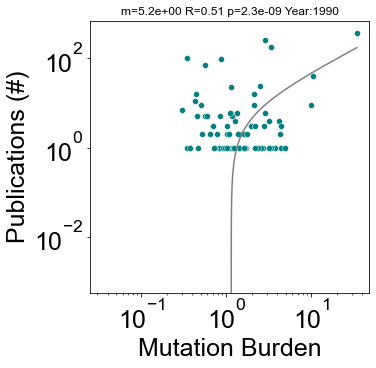

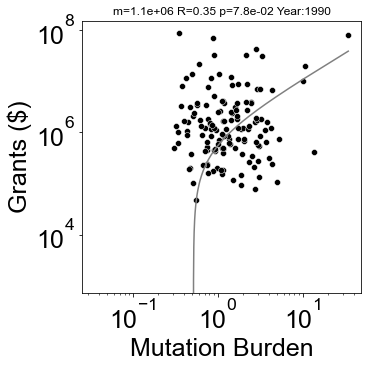

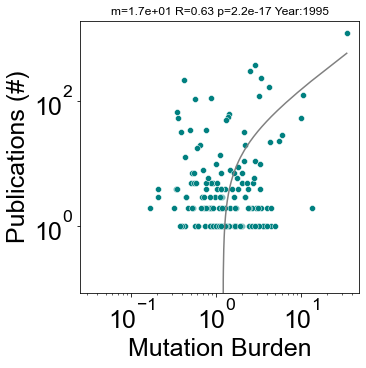

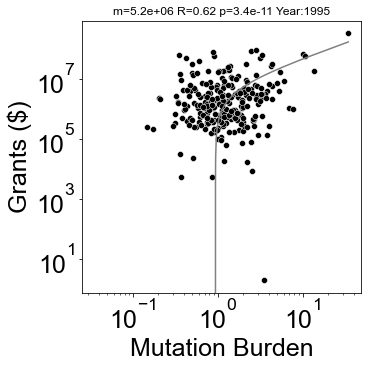

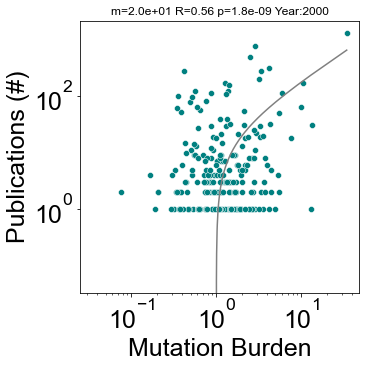

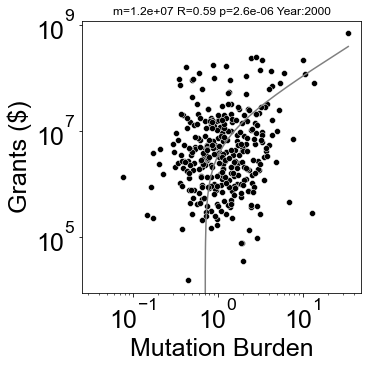

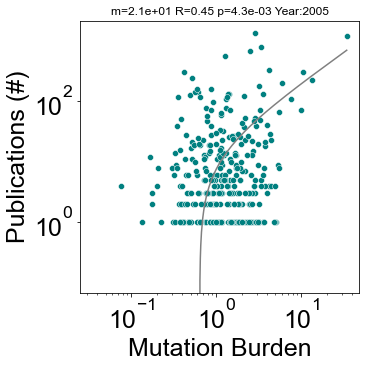

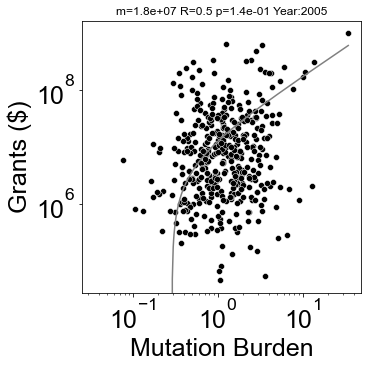

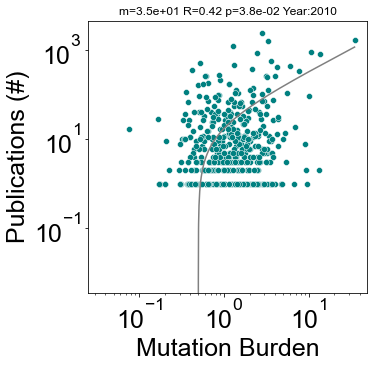

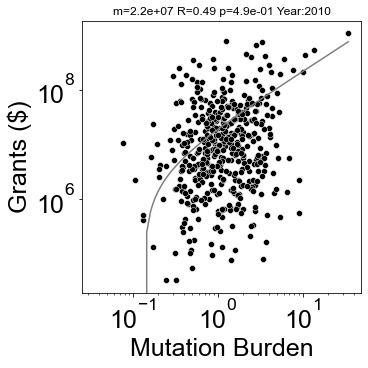

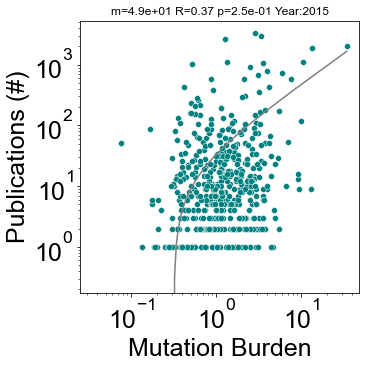

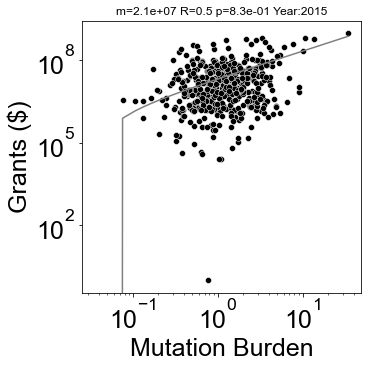

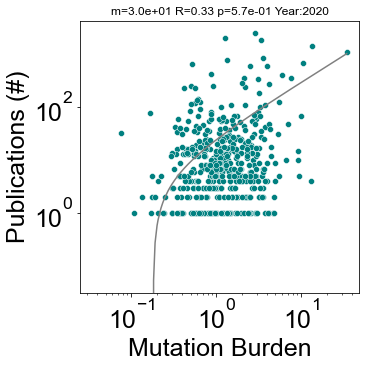

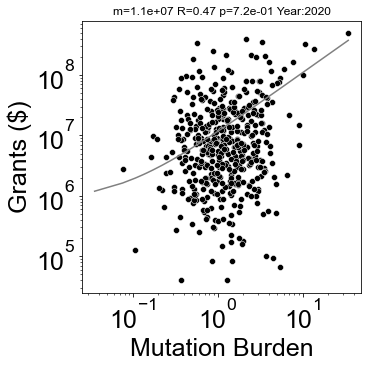

In [20]:
#xy corr plot - extra plots for individual scatter of each time bin
dic_results1=dict()
ylist=['Publications (#)','Grants ($)']
xlabel1='Mutation Burden'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
yearslist=[1990,1995,2000,2005,2010,2015,2020]
dic_results1['Publications (#)']=dict()
dic_results1['Grants ($)']=dict()
for iyear in yearslist:
    idf=df_pubs_grants_timed[df_pubs_grants_timed.Year==iyear]
    xdat=idf[xlabel1].sort_values(ascending=False)

    for il in range(len(ylist)):
        ylabel1=ylist[il]
        ydat=idf[ylabel1].sort_values(ascending=False)
        overlapindex=[idx for idx in xdat.index if idx in ydat.index]
        xvals=xdat.loc[overlapindex].values
        yvals=ydat.loc[overlapindex].values
        Xinp=sm.add_constant(xvals)
        Yinp=yvals
        model1=sm.OLS(Yinp,Xinp)
        results1=model1.fit()
        dic_results1[ylabel1][iyear]=results1
        yvals_predicted=results1.predict(Xinp)
        plt.figure(figsize=(5,5))
        df_plt=pd.concat([xdat,ydat],axis='columns')
        sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
        plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}')+' Year:'+str(iyear),size=12)
        plt.xlabel(xlabel1)
        plt.xscale('log')
        plt.yscale('log')
        fname='Panel12_'+xlabel1+'_vs_'+ylabel1
        plt.plot(xvals,yvals_predicted,color='grey')
    #     plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
        plt.show()

## Panel 13

In [21]:
ylabel1='Publications (#)'
df_Pubs_stats=pd.DataFrame([{'m':dic_results1[ylabel1][ikey].params[1],'R':round(np.sqrt(dic_results1[ylabel1][ikey].rsquared),2),'pvalue':dic_results1[ylabel1][ikey].pvalues[0]} for ikey in dic_results1[ylabel1].keys()],index=dic_results1[ylabel1].keys())
df_Pubs_stats

,m,R,pvalue
1990,5.242595,0.51,2.276505e-09
1995,17.352780,0.63,2.209192e-17
2000,19.625934,0.56,1.797572e-09
2005,20.786547,0.45,4.316436e-03
2010,34.756604,0.42,3.776176e-02
2015,48.549793,0.37,2.538956e-01
2020,29.538772,0.33,5.714634e-01


In [22]:
df_Pubs_stats.R.plot.bar(color=col_dic[ylabel1])
fname='Panel13_'+'Year'+'_vs_'+'Grant_Rvalues'
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

In [23]:
ylabel1='Grants ($)'
df_Grants_stats=pd.DataFrame([{'m':dic_results1[ylabel1][ikey].params[1],'R':round(np.sqrt(dic_results1[ylabel1][ikey].rsquared),2),'pvalue':dic_results1[ylabel1][ikey].pvalues[0]} for ikey in dic_results1[ylabel1].keys()],index=dic_results1[ylabel1].keys())
df_Grants_stats

,m,R,pvalue
1990,1.132768e+06,0.35,7.812277e-02
1995,5.152088e+06,0.62,3.405740e-11
2000,1.151332e+07,0.59,2.603169e-06
2005,1.777174e+07,0.50,1.369349e-01
2010,2.165281e+07,0.49,4.925006e-01
2015,2.145218e+07,0.50,8.349492e-01
2020,1.083304e+07,0.47,7.173079e-01


In [24]:
df_Grants_stats.R.plot.bar(color=col_dic[ylabel1])
fname='Panel13_'+'Year'+'_vs_'+'Publication_Rvalues'
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()